In [2]:
import sys
import os, glob
import os.path
PYTHON = %system which python
HOSTNAME = %system echo $HOSTNAME
print("python dir:     ",PYTHON)
print("HOSTNAME:       ",HOSTNAME)

import warnings
warnings.filterwarnings('ignore')

import csv
import pandas as pd
import numpy as np
print ('Numpy version: ',np.__version__)
import seaborn as sns
import math


import matplotlib
import matplotlib as plt
from matplotlib import pyplot as plt

from itertools import combinations
from collections import OrderedDict

home=os.path.expanduser('~')

pd.set_option('display.max_rows', None, 
              'display.max_columns', None,
              'display.max_colwidth', None)

from IPython.display import Image
import matplotlib.image as mpimg
from matplotlib import rcParams

sys.path.append('/Users/rezvanchitsazi/gpcr/desmond/analysis/python-tcl')
 
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD
from MDAnalysis.analysis import pca, align

import mdtraj as mdt
print('')
print('MDAnalysis version: ', mda.__version__)
print('')

import ipywidgets 
import nglview as nv

%matplotlib inline
%pylab inline

%load_ext autoreload
%autoreload 2

python dir:      ['/Users/rezvanchitsazi/opt/anaconda3/bin/python']
HOSTNAME:        ['[dhcp-10-8-038-197.mobile.reshsg.uci.edu]']
Numpy version:  1.22.4

MDAnalysis version:  2.1.0



Populating the interactive namespace from numpy and matplotlib


# <font color=darkcyan> Principal Component Analysis (PCA):
> ### &#10148; PCA for protein dynamics is a technique that reduces the complexity of the conformational space of a protein by identifying the principal modes of motion from its trajectory. <br>
> ### &#10148; PCA analyzes the covariance matrix of the atomic positions and extracts a set of orthogonal eigenvectors (principal components or PCs) that describe the dominant collective motions of the protein. <br> 
> ### &#10148; These PCs are ordered according to the magnitude of their associated eigenvalues, which represent the amount of variance in the trajectory that is explained by each PC. <br> 
> ### &#10148; Projecting the trajectory onto the PCs, the essential motions of the protein can be visualized and quantified, providing insights into its dynamic behavior and functional mechanisms. <br> 


> # <font color=darkcyan> PCA analysis to study the essential dynamics of:
> ### &#10148; <font color=grey> GPCR (ACKR3) <font color=black> bound with two different chemokines <font color=orangered >(CXCL12) <font color=black> & <font color=lightcoral>(CCX662):
> ### &#10148; 50% of the frames/per ligand for analysis (7500 frame = CXCL12 & 7500 frame = CCX662)

# <mark> Parameters for PCA <mark>

In [3]:
top='resample.pdb'
trj='resample_combined.dcd'

'''alignment: receptor TM region, N-terminus and loops are excluded'''
'''pca analysis: receptor TM region (backbone). N-terminus and loops are excluded'''

align_sel="segid C2 and (resid 41:71 or resid 81:106 \
or resid 114:146 or resid 160:181 or resid 205:238 \
or resid 251:279 or resid 287 :318) and not (name H*)"

pca_sel='segid C2 and (resid 41:71 or resid 81:106 \
or resid 114:146 or resid 160:181 or resid 205:238 \
or resid 251:279 or resid 287:318) and name CA'


# <mark> List the selection <mark>

In [4]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', None)

u = mda.Universe(top,trj)
calpha=list(u.select_atoms("resid 41:71   or resid 81:106 or \
                     resid 114:146 or resid 160:181 or \
                     resid 205:238 or resid 251:279 or resid 287:318 and name CA"))

ca = pd.DataFrame (calpha, columns=['index'])
ca['index'].head(5)

0    <Atom 77: CA of type C of resname SER, resid 41 and segid C2 and altLoc >
1    <Atom 82: CA of type C of resname VAL, resid 42 and segid C2 and altLoc >
2    <Atom 87: CA of type C of resname LEU, resid 43 and segid C2 and altLoc >
3    <Atom 92: CA of type C of resname LEU, resid 44 and segid C2 and altLoc >
4    <Atom 97: CA of type C of resname TYR, resid 45 and segid C2 and altLoc >
Name: index, dtype: object

# <mark> Perform PCA on selection <mark>

In [5]:
n_components_trans=5
n_project=0

print('No of PC components for transformation: ', n_components_trans)
print('Projecting & Visualizing PC #' + str(n_project+1))
print('********************************************************************************')

u = mda.Universe(top,trj)
aligner = align.AlignTraj(u, u, select=align_sel, in_memory=True).run()
pc = pca.PCA(u, select=pca_sel,align=False, mean=None,n_components=None).run()
    
backbone = u.select_atoms(pca_sel)
n_bb = len(backbone)
print('There are {} backbone atoms in the analysis'.format(n_bb))
print('PC components shape: ', pc.results.p_components.shape)
print('mean shape: ', pc.mean.shape)
print('')

array=pc.results.p_components
array.tofile('pc_components.csv',sep=',',format='%10.5f')

'''Raw variance explained by each eigenvector of the covariance matrix.'''
print('PC1 variance ', pc.results.variance[0])
print('PC2 variance',  pc.results.variance[1])
print('PC3 variance',  pc.results.variance[2])

print('')
'''Percentage of variance explained by the selected components and the sum of the components preceding it.'''
print('PC1 acumulated variance ', pc.results.cumulated_variance[0])
print('PC2 acumulated variance ', pc.results.cumulated_variance[1])
print('PC3 acumulated variance ', pc.results.cumulated_variance[2])
print('PC4 acumulated variance ', pc.results.cumulated_variance[3])
print('PC5 acumulated variance ', pc.results.cumulated_variance[4])
print('')

pc_var=[]
for i in range (10):
    
    pc_var.append(pc.results.cumulated_variance[i])

print(pc_var)
result=pd.DataFrame(pc_var)
print(result)
result.to_csv('pc_var_result.csv')
#**************************************************************************************************
'''TRANSFORMATION: pc.T * u; pc=d*k {d=dimension (3N) & k=no of PCs} ??''' 
''' Transform the data to a new space or subspace'''

n_pcs = np.where(pc.results.cumulated_variance > 0.95)[0][0]
print(n_pcs)
transformed = pc.transform(backbone, n_components=n_components_trans)
print('transformation shape (n_frames, n_components): ',transformed.shape)
print('')
    
'''save for plotting'''
data = pd.DataFrame(transformed, columns=['PC{}'.format(i+1) for i in range(n_components_trans)])
data['Time (ps)'] = data.index * 0.24
data.reset_index(inplace=True)
data = data.rename(columns = {'index':'frame'})   
data.to_csv('PCA.csv')
#**************************************************************************************************
'''PROJECTION; pick frames; all or sub-set of frames ??'''
'''results.p_components:
Principal components of the feature space, representing the directions of maximum variance in the data. 
The column vector p_components[:, i] is the eigenvector corresponding to the variance[i].'''

pc_projected = pc.results.p_components[:, n_project]
trans=transformed[:, n_project]
projected=np.outer(trans,pc_projected)+pc.mean.flatten() 

print('pc_projected shape: ',pc_projected.shape)
print('pc_transformed; n_frmaes: ',trans.shape)
print('projected: ',projected.shape)

coordinates = projected.reshape(len(trans), -1, 3)

proj = mda.Merge(backbone)
proj.load_new(coordinates, order='fac')


pc_projected = nv.show_mdanalysis(proj.atoms)
pc_projected

No of PC components for transformation:  5
Projecting & Visualizing PC #1
********************************************************************************
There are 207 backbone atoms in the analysis
PC components shape:  (621, 621)
mean shape:  (207, 3)

PC1 variance  39.1886827984155
PC2 variance 21.85314637819572
PC3 variance 21.299960062994927

PC1 acumulated variance  0.18521776129291315
PC2 acumulated variance  0.28850244861441193
PC3 acumulated variance  0.38917260736381215
PC4 acumulated variance  0.4746155142934112
PC5 acumulated variance  0.5174099568797388

[0.18521776129291315, 0.28850244861441193, 0.38917260736381215, 0.4746155142934112, 0.5174099568797388, 0.5491309385744546, 0.576772373785869, 0.6005081808906406, 0.621802193210747, 0.6396097403233252]
          0
0  0.185218
1  0.288502
2  0.389173
3  0.474616
4  0.517410
5  0.549131
6  0.576772
7  0.600508
8  0.621802
9  0.639610
116
transformation shape (n_frames, n_components):  (22875, 5)

pc_projected shape:  (621,)

NGLWidget(max_frame=22874)

# <mark> Plot PCs variance as bar graph <mark>

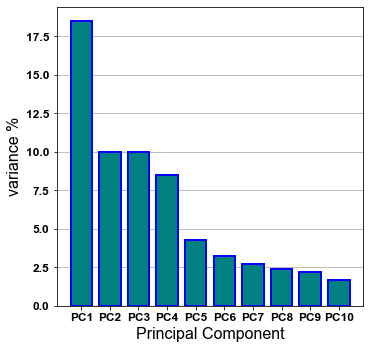

In [6]:
var=pd.read_csv('pc_var_result.csv')
var

import matplotlib.pyplot as plt

plt.rcParams['font.family'] = "Arial"
plt.rcParams['font.size'] = '16'
plt.rcParams['font.weight']='bold'
plt.rcParams['grid.linestyle']='-'
plt.rcParams['axes.axisbelow'] = True

fig = plt.figure(figsize = (5.5, 5.5))
PCs = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5','PC6','PC7','PC8','PC9','PC10']
var = [0.185,0.10,0.10,0.085,0.043,0.032,0.027,0.024,0.022,0.017]
result = [item * 100 for item in var]
plt.bar(PCs,result, width=0.75, align='center', color='teal', edgecolor='blue',
       linewidth=2)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Principal Component')
plt.ylabel('variance %')
plt.grid(True, axis='y')
plt.savefig('PCs_variance.pdf', dpi=300)
plt.show()

(621,)
207
(207,)


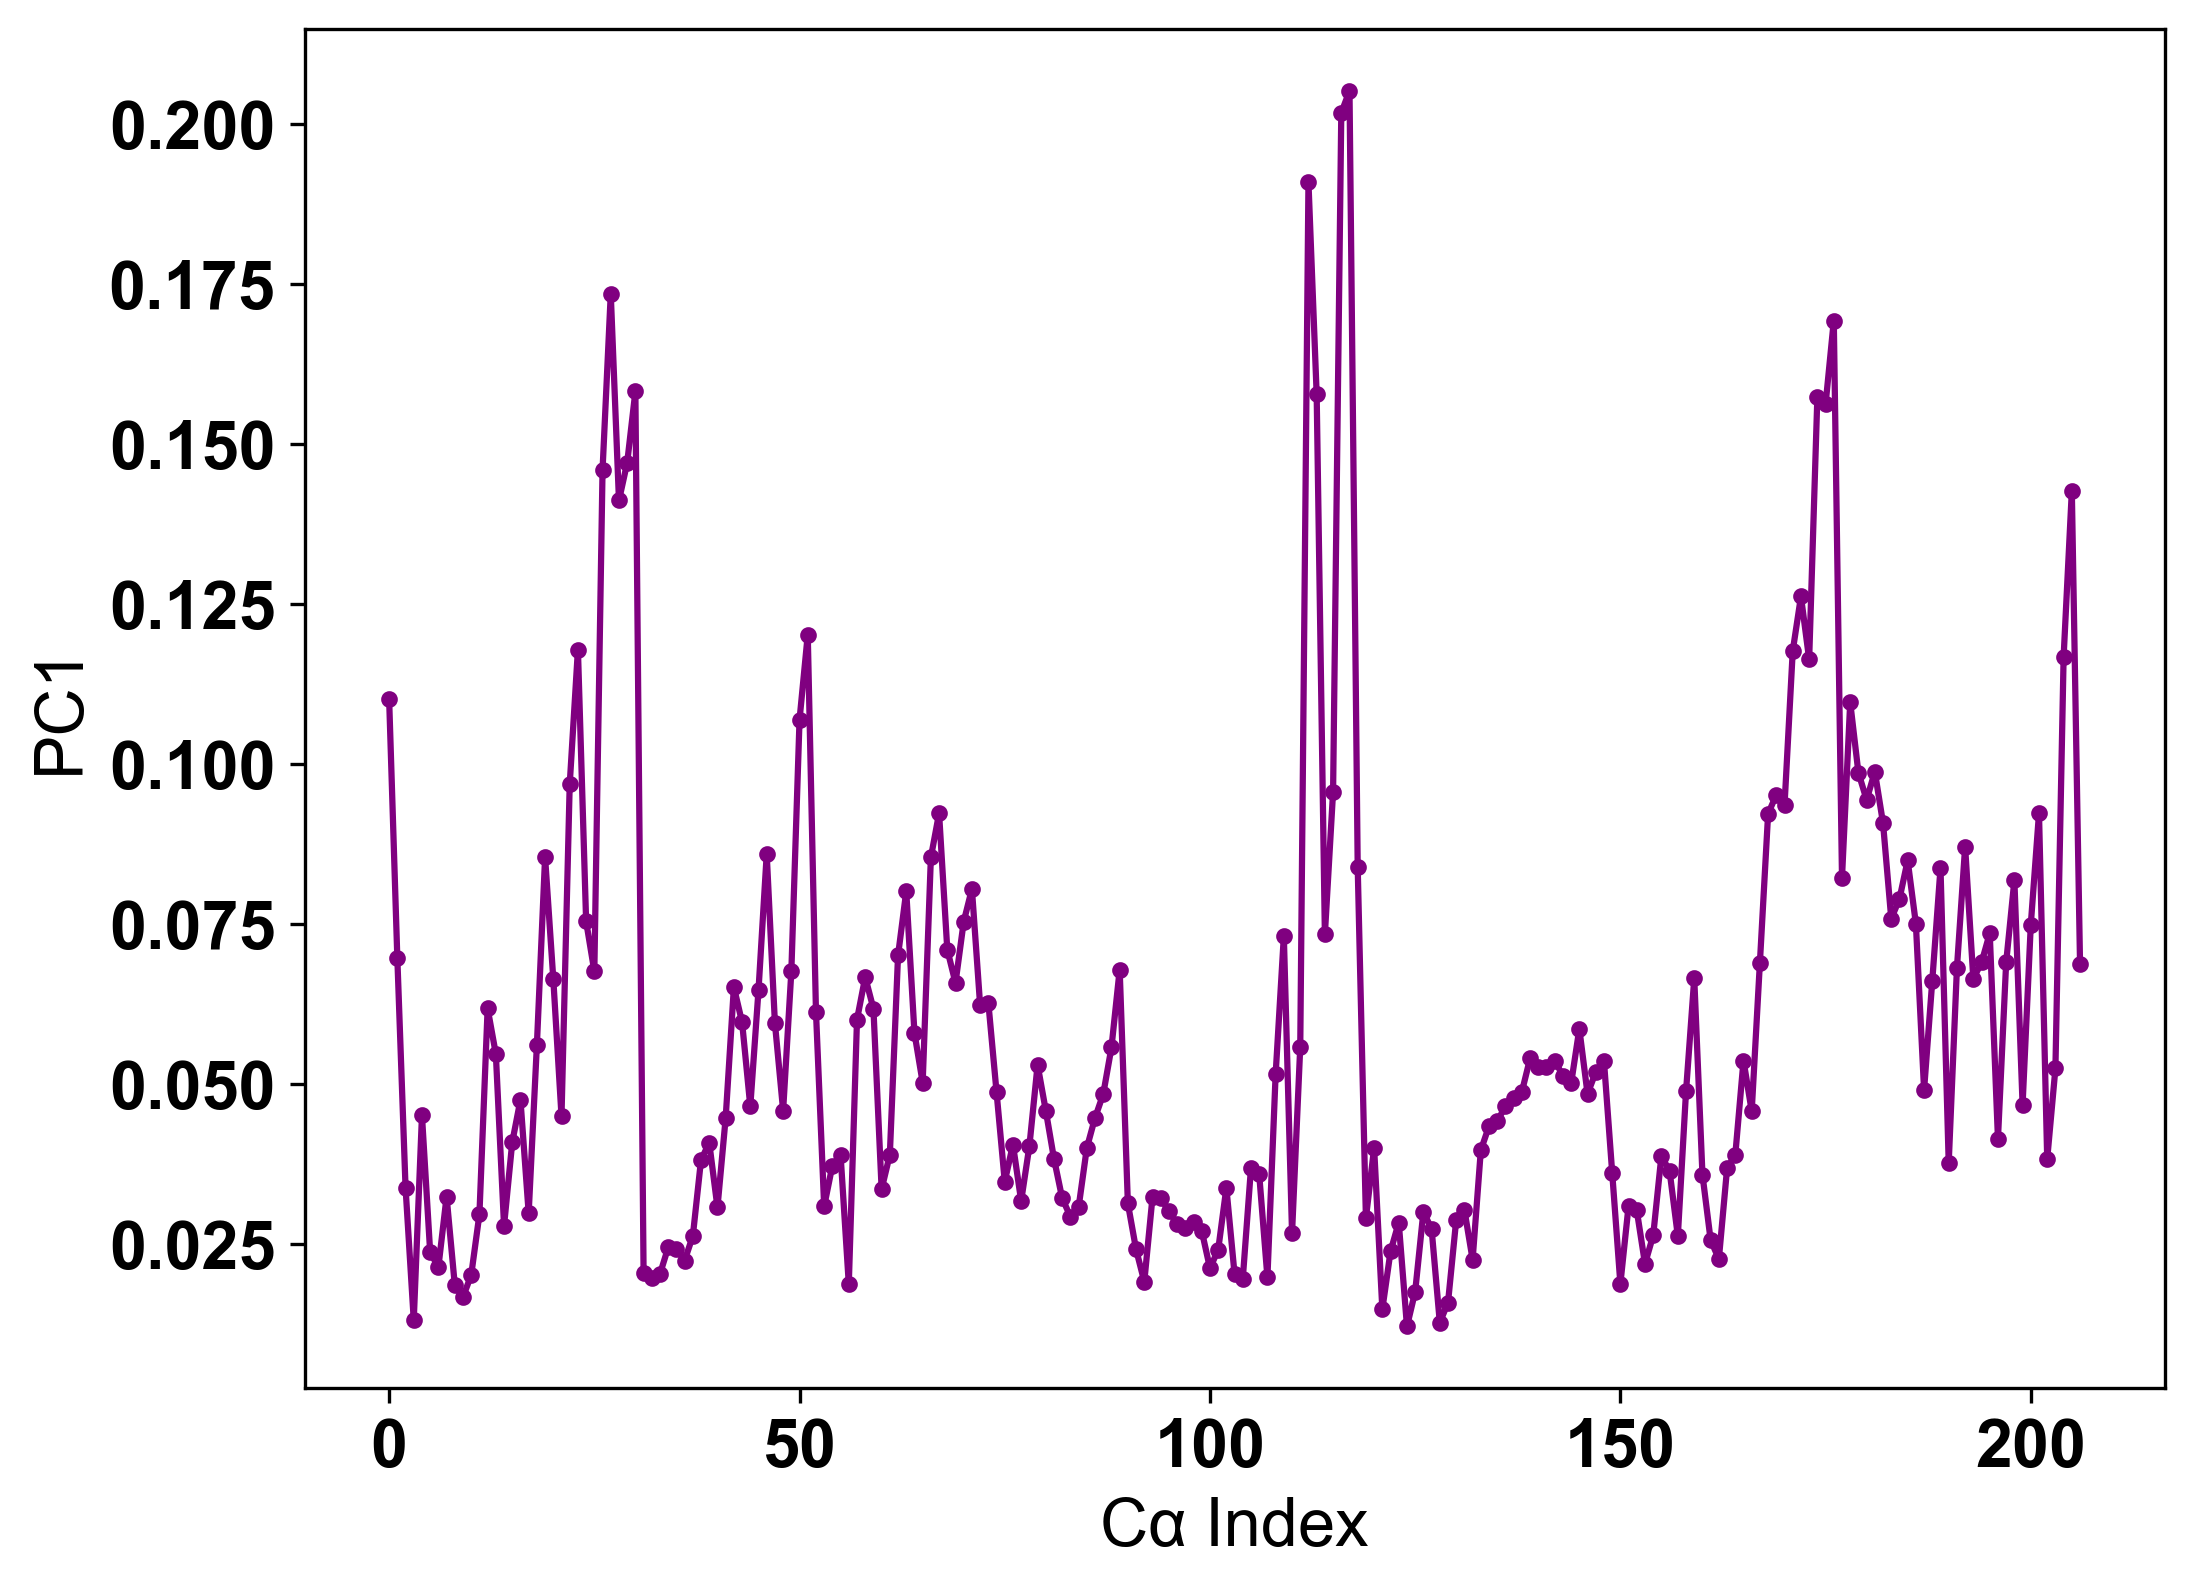

In [7]:
'''results.p_components(n_atoms*3, n_components):
Principal components of the feature space, representing the directions of maximum variance in the data. 
The column vector p_components[:, i] is the eigenvector corresponding to the variance[i].'''

from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=300)

pc_n=0
pc_projected = pc.results.p_components[:,pc_n]
print(pc_projected.shape)
#print(pc_projected[:])
d=(len(pc_projected)/3)
d=int(d)
print(d)

reshaped = np.reshape(pc_projected, (-1, 3))
aa=np.sqrt(np.sum(np.square(reshaped), axis=1))
print(aa.shape)

np.savetxt('PC1vector.csv', aa, delimiter=",")

import numpy as geek
#print ("Input unsorted array : ", aa)
 
out_arr = geek.argsort(aa)
#print ("Output sorted array indices : ", out_arr)
#print("Output sorted array : ", aa[out_arr])

import matplotlib.pyplot as plt

'''\alpha then press tab'''
plt.plot(aa, color='purple', marker='.')
plt.xlabel("Cα Index")
plt.ylabel('PC1')
plt.savefig('residue-PC1.pdf', dpi=300)
plt.show()


(621,)
207
(207,)


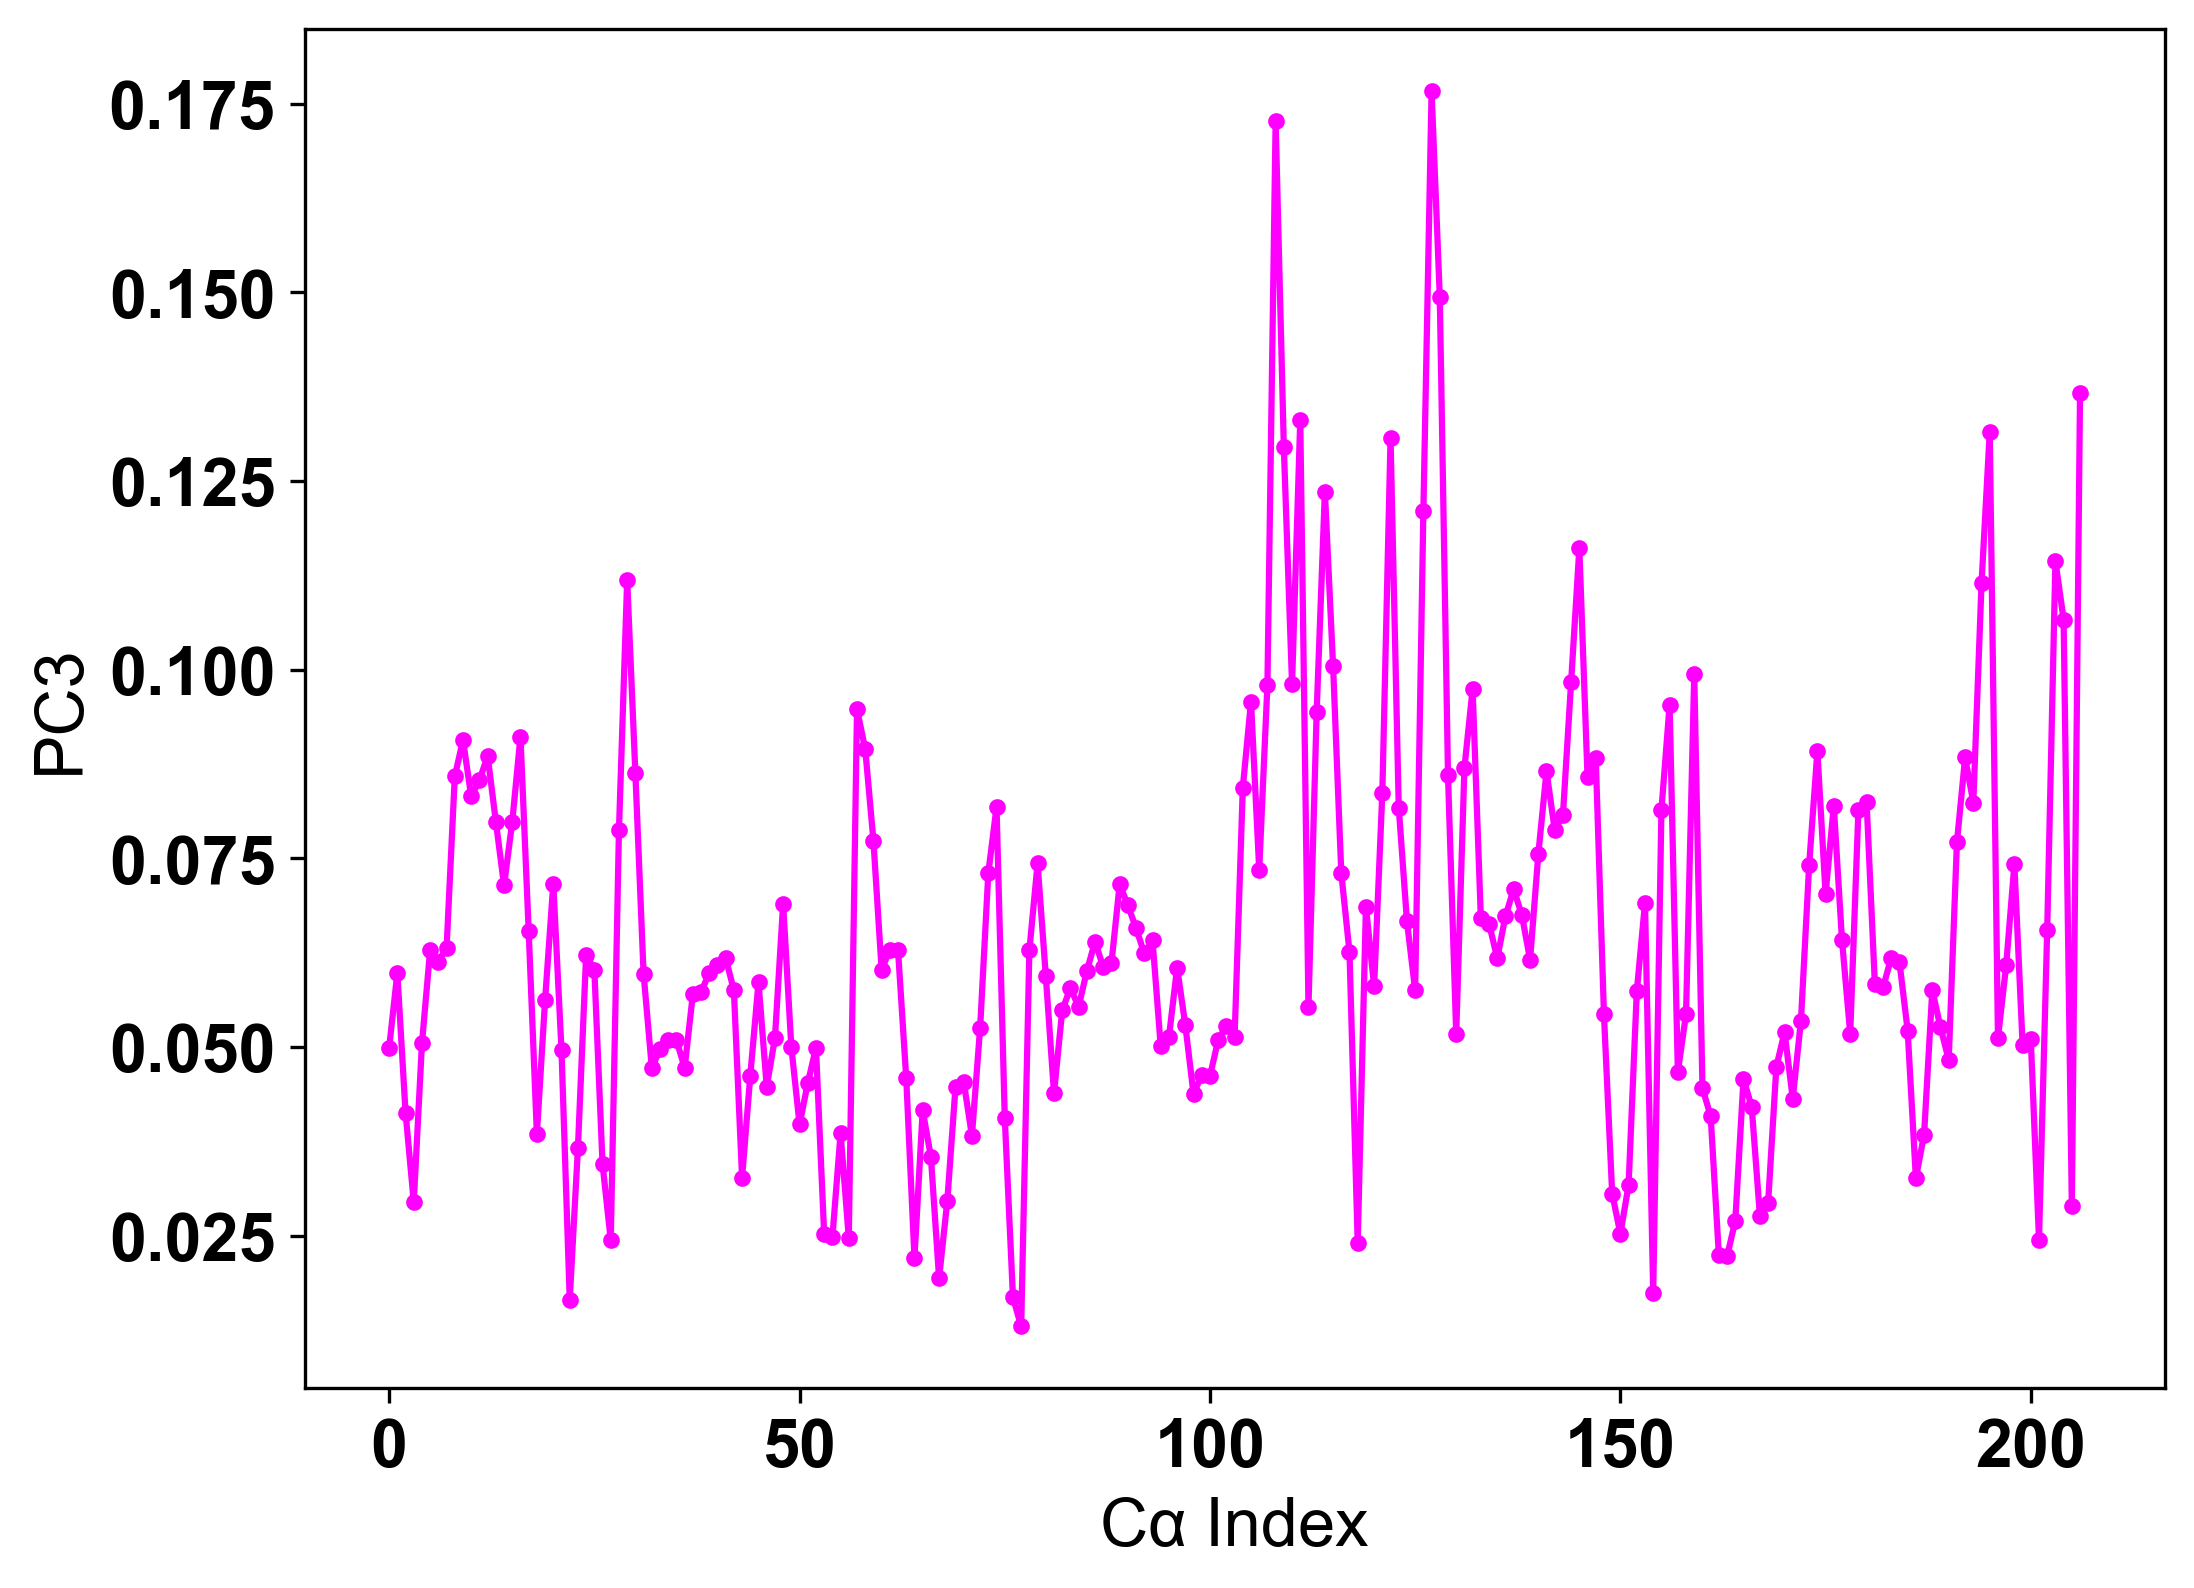

In [8]:
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=300)

pc_n=2
pc_projected = pc.results.p_components[:,pc_n]
print(pc_projected.shape)
#print(pc_projected[:])
d=(len(pc_projected)/3)
d=int(d)
print(d)

reshaped = np.reshape(pc_projected, (-1, 3))
aa=np.sqrt(np.sum(np.square(reshaped), axis=1))
print(aa.shape)


import numpy as geek
#print ("Input unsorted array : ", aa)
 
out_arr = geek.argsort(aa)
#print ("Output sorted array indices : ", out_arr)
#print("Output sorted array : ", aa[out_arr])

import matplotlib.pyplot as plt

'''\alpha then press tab'''
plt.plot(aa, color='magenta', marker='.')
plt.xlabel("Cα Index")
plt.ylabel('PC3')
plt.savefig('residue-PC3.pdf', dpi=300)
plt.show()

# <mark> Parameters for Plot <mark>

In [9]:
def plt_pca(keyword,L1_frame, L2_frame, trj1=0,trj2=0,trj3=0,frame=0):
    
   
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    '''This is for boot sampling:
    frame:variable in the name of the file with bootstrap indices
    trj1: no of frames in traj1, make sure the no is the same for both ligands
    trj2: no of frames in traj2, make sure the no is the same for both ligands
    trj3: no of frames in traj3, make sure the no is the same for both ligands'''
    
    df=pd.read_csv('PCA.csv')

    n_rows=df.shape[0]
    print(n_rows)

    Lig1=int(n_rows/2)
    Lig2=int(n_rows - Lig1)
    print(Lig1)
    print(Lig2)

    L1= df.iloc[0:L1_frame]
    L2= df.iloc[L1_frame+1:L2_frame]
#--------------------------------------

    if keyword=='boot':
        '''mapping (if we randomly select frames with bootstrapping)'''
        ind_Lig1=pd.read_csv('cxcl12_idx_boot_' + str(frame) + '.csv', header=None, delim_whitespace=True)
        ind_Lig1.columns =['frame', 'boot']
        ind_Lig2=pd.read_csv('ccx662_idx_boot_' + str(frame) + '.csv',header=None, delim_whitespace=True )
        ind_Lig2.columns =['frame', 'boot']

        '''Lig1 = CXCL12'''
        Lig1_traj1=ind_Lig1.loc[ind_Lig1['boot'] < trj1]
        Lig1_traj2=ind_Lig1.loc[(ind_Lig1['boot'] > trj1+1) & (ind_Lig1['boot'] < trj2)]
        Lig1_traj3=ind_Lig1.loc[(ind_Lig1['boot'] > trj2+1) & (ind_Lig1['boot'] < trj3)]
    
        Lig1_list_traj1=Lig1_traj1['frame'].tolist()
        Lig1_list_traj2=Lig1_traj2['frame'].tolist()
        Lig1_list_traj3=Lig1_traj3['frame'].tolist()

        df.loc[df.index[Lig1_list_traj1], 'Lig'] = 'cxcl12-traj1'
        df.loc[df.index[Lig1_list_traj2], 'Lig'] = 'cxcl12-traj2'
        df.loc[df.index[Lig1_list_traj3], 'Lig'] = 'cxcl12-traj3'
#-----------------------------------------------------------------------------------------
        '''Lig2 = CCX662'''
        Lig2_traj1=ind_Lig2.loc[ind_Lig2['boot'] < trj1]
        Lig2_traj2=ind_Lig2.loc[(ind_Lig2['boot'] > trj1+1) & (ind_Lig2['boot'] < trj2)]
        Lig2_traj3=ind_Lig2.loc[(ind_Lig2['boot'] > trj2+1) & (ind_Lig2['boot'] < trj3)]

        Lig2_list_traj1=Lig2_traj1['frame'].tolist()
        Lig2_list_traj2=Lig2_traj2['frame'].tolist()
        Lig2_list_traj3=Lig2_traj3['frame'].tolist()

        df.loc[df.index[Lig2_list_traj1], 'Lig'] = 'ccx662-traj1'
        df.loc[df.index[Lig2_list_traj2], 'Lig'] = 'ccx662-traj2'
        df.loc[df.index[Lig2_list_traj3], 'Lig'] = 'ccx662-traj3'
#---------------------------------------------------------------------------------------
    elif keyword=='all':
        '''mapping if we include all frames'''
        '''Lig1 = CXCL12'''
        Lig1_traj1=df.loc[df['frame'] <  4999]
        Lig1_traj2=df.loc[(df['frame'] > 5000) & (df['frame'] <  7749)]
        Lig1_traj3=df.loc[(df['frame'] > 7750) & (df['frame'] < 10499)]
    
        Lig1_list_traj1=Lig1_traj1['frame'].tolist()
        Lig1_list_traj2=Lig1_traj2['frame'].tolist()
        Lig1_list_traj3=Lig1_traj3['frame'].tolist()

        df.loc[df.index[Lig1_list_traj1], 'Lig'] = 'cxcl12-traj1'
        df.loc[df.index[Lig1_list_traj2], 'Lig'] = 'cxcl12-traj2'
        df.loc[df.index[Lig1_list_traj3], 'Lig'] = 'cxcl12-traj3'
#-----------------------------------------------------------------------------------------
        '''Lig2 = CCX662'''
        Lig2_traj1=df.loc[(df['frame'] > 10500) & (df['frame'] < 15499)]
        Lig2_traj2=df.loc[(df['frame'] > 15500) & (df['frame'] < 19249)]
        Lig2_traj3=df.loc[(df['frame'] > 19250) & (df['frame'] < 22875)]

        Lig2_list_traj1=Lig2_traj1['frame'].tolist()
        Lig2_list_traj2=Lig2_traj2['frame'].tolist()
        Lig2_list_traj3=Lig2_traj3['frame'].tolist()

        df.loc[df.index[Lig2_list_traj1], 'Lig'] = 'ccx662-traj1'
        df.loc[df.index[Lig2_list_traj2], 'Lig'] = 'ccx662-traj2'
        df.loc[df.index[Lig2_list_traj3], 'Lig'] = 'ccx662-traj3'

    df.to_csv('PCA_hue.csv')

    L1.to_csv('Lig1.csv')
    L2.to_csv('Lig2.csv')


    data=df[['PC1','PC2','PC3','Lig']]
    
    palette = {
    'cxcl12-traj1': 'xkcd:lavender',
    'cxcl12-traj2': 'xkcd:violet',
    'cxcl12-traj3': 'xkcd:bright pink',
    'ccx662-traj1': 'xkcd:orange',
    'ccx662-traj2': 'xkcd:golden yellow',
    'ccx662-traj3': 'xkcd:pumpkin',
}

    g = sns.PairGrid(data, hue='Lig', palette=palette)
    g.map_diag(sns.histplot)
    #g.map_diag(sns.histplot, color=".3")
    g.map_offdiag(sns.scatterplot)
    g.add_legend()
    g.add_legend()

    plt.savefig('PCA.pdf', dpi=300)

22875
11437
11438


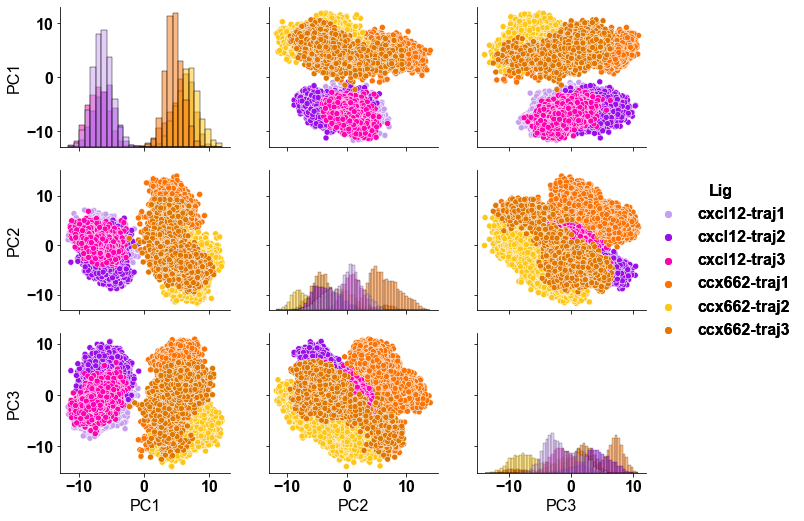

In [10]:
plt_pca('all',10500, 22875)

> ### &#10148; Data is transformed into a new axis (subspace/space) <br>
> ### &#10148; There is 3N dimensional data in each frame & very hard to plot and visualize <br>
> ### &#10148; Instead we trasnform those data into a new space (axis ~ principal axis) so we can show each frame with a single data point or several data points which are named as PC1, PC2, ...PCn <br>
> ### &#10148; The motions of protein can usually be explained with few principal components <br>

In [11]:
df=pd.read_csv('PCA.csv', index_col=[0])
df.head(10)


,frame,PC1,PC2,PC3,PC4,PC5,Time (ps)
0,0,-2.911946,1.972895,-6.577384,-4.178657,0.123466,0.00
1,1,-6.133342,0.689458,-6.425342,-3.235010,-1.294403,0.24
2,2,-4.669350,0.605158,-4.346045,-2.645444,-2.706037,0.48
3,3,-4.889374,-0.851224,-2.789006,-3.736185,0.218940,0.72
4,4,-4.929397,-0.849189,-2.542445,-2.036040,-5.112834,0.96
5,5,-2.805497,0.199574,-5.180219,-2.289344,-3.346359,1.20
6,6,-2.576035,-2.316800,-4.189133,-4.666968,-3.134109,1.44
7,7,-4.086786,-0.639152,-2.948692,-2.547994,-4.540637,1.68
8,8,-4.366563,-0.895283,-2.986105,-3.985347,-1.238977,1.92
9,9,-5.166823,0.011446,-3.429030,-4.269838,-2.176163,2.16


# Porcupine Plots ??

# <mark> K-means Clustering <mark>

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import make_blobs
def elbow_method(data):
    """ How to pick number of clusters (KMeans Clustering)
     Elbow method (bending point is known as 'Elbow Point')
    within cluster sum of squared errors (WSSE)
    """
    data=pd.read_csv(data)
    data=data[['PC1','PC2']]
    
    k_rng = range(2,12)
    SSE = []

    for cluster in k_rng:
            kmeans = KMeans(n_clusters = cluster, init='k-means++', algorithm='full')
            kmeans.fit(data)
            SSE.append(kmeans.inertia_)


    frame = pd.DataFrame({'Cluster':k_rng, 'SSE':SSE})
    plt.figure(figsize=(12,6))
    plt.plot(frame['Cluster'], frame['SSE'], marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('WSS (Inertia)');


# <mark> Elbow Method <mark>

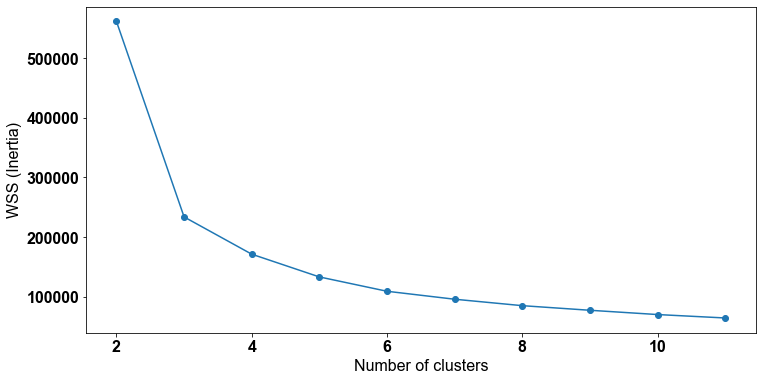

In [13]:
elbow_method('PCA.csv')

In [14]:
from sklearn.metrics import pairwise_distances_argmin_min
nframe=15000
data=pd.read_csv('PCA.csv', delimiter=',')
data=data[['PC1','PC2']]
PCs = data[:].values
PCs
X = pd.DataFrame(PCs).to_numpy()
X.shape

random_state = 200
init = 'random'
cluster=3

kmeans = KMeans(n_clusters=cluster, init = init, random_state=random_state,max_iter=600, tol=0.0001)
kmeans.fit(X)
kmeans_pred = kmeans.predict(X)

            PC1       PC2
21696  6.467953 -4.271346
21792  6.587272 -4.402900
16756  6.502896 -4.345564
20543  6.485837 -4.238335
22857  6.624001 -4.270418
           PC1       PC2
2400 -6.559813 -0.634684
5391 -6.515900 -0.657063
1279 -6.553530 -0.671031
4215 -6.506860 -0.666973
9282 -6.469854 -0.648639
            PC1       PC2
14814  4.469349  5.824617
14006  4.541182  5.778246
19385  4.385335  5.774591
15213  4.551860  5.832732
10807  4.490165  5.670225
[2 2 2 ... 0 0 0]
[[ 6.54080411 -4.32337452]
 [ 4.48119932  5.76849145]
 [-6.51788176 -0.68253138]]
number of clusters is: 3
number of rows belong to each cluster
2    10510
0     6356
1     6009
Name: cluster, dtype: int64
-------------------------------------------------------------------------------------------
(6356,)
center-0 [ 6.54080411 -4.32337452]
[[ 1.86377584 -0.86954588]
 [ 2.53456764 -1.13808917]
 [ 3.96642506 -0.18738969]
 ...
 [ 5.63665474 -3.44948297]
 [ 5.55586193 -2.00538718]
 [ 3.87179123 -2.95315231]]
nearest
[ar

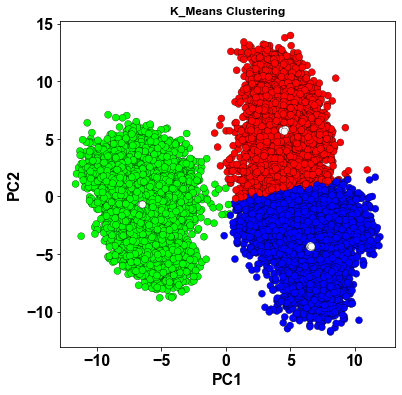

In [15]:
from sklearn.metrics import pairwise_distances_argmin_min
nframe=15000
data=pd.read_csv('PCA.csv', delimiter=',')
data=data[['PC1','PC2']]
PCs = data[:].values
PCs
X = pd.DataFrame(PCs).to_numpy()
X.shape


#----------------------
L1_indexes = [21696, 21792, 16756, 20543, 22857]
L2_indexes = [2400, 5391, 1279, 4215, 9282]
L3_indexes = [14814, 14006, 19385, 15213, 10807]

L1=(data.iloc[L1_indexes])
L2=(data.iloc[L2_indexes])
L3=(data.iloc[L3_indexes])
print (L1)
print (L2)
print (L3)
#-----------------------------------

random_state = 200
init = 'random'
cluster=3

kmeans = KMeans(n_clusters=cluster, init = init, random_state=random_state,max_iter=600, tol=0.0001)
kmeans.fit(X)
kmeans_pred = kmeans.predict(X)

centers = kmeans.cluster_centers_
labels = kmeans.labels_

print(labels)
print(centers)

print('number of clusters is:', len(centers))
print('number of rows belong to each cluster')

frame = pd.DataFrame(X)
frame['cluster'] = kmeans_pred
print(frame['cluster'].value_counts())

f, ax = plt.subplots(figsize=(6,6))
plt.style.use('seaborn')

ax.set_title('K_Means Clustering',fontweight ='bold')
ax.set_xlabel('PC1',fontweight ='bold')
ax.set_ylabel('PC2',fontweight ='bold')
ax.scatter(X[:,0],X[:,1],c=kmeans.labels_,cmap='brg', edgecolor=('k'));

ax.scatter(x='PC1',y='PC2',data=L1, c='white', edgecolor=('k'))
ax.scatter(x='PC1',y='PC2',data=L2, c='white', edgecolor=('k'))
ax.scatter(x='PC1',y='PC2',data=L3, c='white', edgecolor=('k'))

plt.savefig('Kmeans.pdf', dpi=300)


print('-------------------------------------------------------------------------------------------')

''' save 10 representative frames'''
idx0=np.where(kmeans.labels_ == 0)[0]
print(idx0.shape)
print('center-0', centers[0])
print(X[idx0])


'''find N nearest neighbor'''
from sklearn.metrics import pairwise_distances

distances = pairwise_distances(centers, X , metric='euclidean')
ind = [np.argpartition(i, 10)[:10] for i in distances]
closest = [X[indexes] for indexes in ind]

print('nearest')
print(ind)
print(closest)

print('----------------------------------------------------------------------------------------')

''' Save indices for each cluster '''
    
mydict = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
print(mydict)

for i in range(cluster):
    indices = list(mydict[i])
    indices_array = np.array(indices)
    np.savetxt('clust_km_'+ str(i) + '.csv', indices_array.astype(int), fmt='%i')
        
print('--------------------------------------------------------------------------------------------')   
       
''' save index for one representative frame from each cluster
        for Pymol visualization'''
    
idx0=np.where(kmeans.labels_ == 0)[0]
idx1=np.where(kmeans.labels_ == 1)[0]
idx2=np.where(kmeans.labels_ == 2)[0]
idx3=np.where(kmeans.labels_ == 3)[0]

closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)
print('representative',closest)

'''cluster 1 (3640) - CCX662: representative frame 22980
   cluster 2 (4883) - CXCL12: representative frame 9852 '''

print('idx0',idx0.shape)

# <mark> MDTraj <mark>

In [16]:
import mdtraj as mdt
traj = mdt.load(trj, top=top)
pca_sel='(protein and name CA and (residue 41 to 71 or residue 81 to 106 \
or residue 114 to 146 or residue 160 to 181 \
or residue 205 to 238 or residue 251 to 279 or residue 287 to 318))' 

traj.restrict_atoms(traj.topology.select(pca_sel))
traj.superpose(traj, 0)

view = nv.show_mdtraj(traj)
view.add_representation("ball+stick", selection="protein")
view

NGLWidget(max_frame=22874)

coordinates shape:  (22875, 205, 3)
Frame:  (22875,)


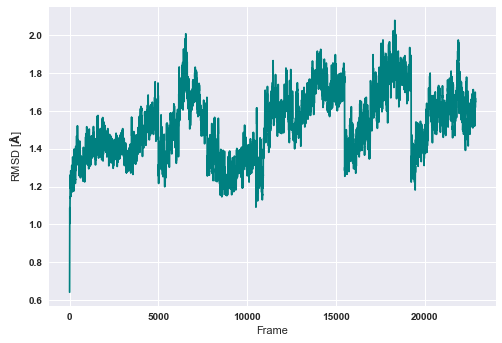

In [17]:
print('coordinates shape: ',traj.xyz.shape)
print('Frame: ',traj.time.shape)
timing=(traj.time)*0.24
t=pd.DataFrame(timing, columns=['Time (ps)'])

rmsds = mdt.rmsd(traj, traj, 0)

'''rolling average'''
def moving_average(x, w):
    rolling=np.convolve(x, np.ones(w),'valid')/ w
    return rolling

data=(moving_average(rmsds, 5))
 
fig, ax=plt.subplots()
ax.plot(data*10, color='teal')
ax.set_xlabel("Frame")
ax.set_ylabel("RMSD [$\mathrm{\AA}$]");

# <font color=black> Notes on <font color=green> variance <font color=black> and <font color=blue> covariance:
> ### &#10148; <font color=green> Variance <font color=black>: measure of dispersion and can be defined as the spread of data from the mean of the given dataset. <br>  
> ### &#10148; <font color=blue> Covariance <font color=black>: between two variables and is used to measure how the two variables vary together   
> ### &#10148; <font color=blue> Covariance <font color=black> matrix depicts <font color=green> variance  <font color=black> of datasets and <font color=blue> covariance  <font color=black> of a pair of datasets in matrix format. 
> ### &#10148; The diagonal elements represent the  <font color=green> variance  <font color=black> of a dataset and the off-diagonal terms give the  <font color=blue> covariance  <font color=black> between a pairs of datasets    
> ### &#10148; The number of variables determines the dimension of a <font color=green>variance-<font color=blue>covariance<font color=black> matrix  
> ### &#10148; e.g. N atoms (x,y,z) = square, symmetric, and positive semi-definite matrix (3N by 3N)
> ### &#10148; All eigenvalues of the <font color=green>variance-<font color=blue>covariance <font color=black> matrix are real and non-negative

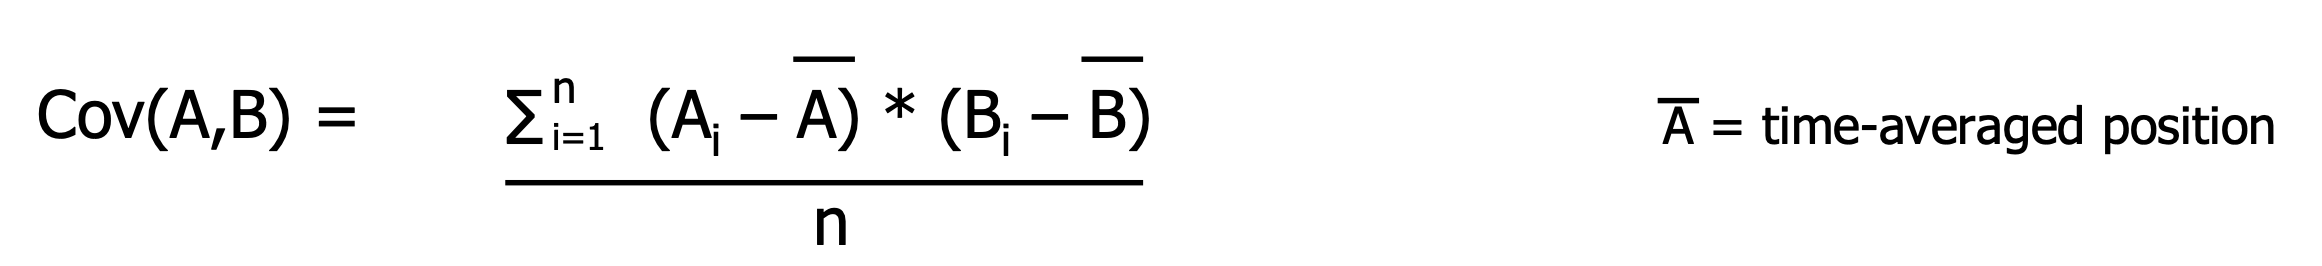

In [18]:
covariance = Image(filename=(home + '/gpcr/desmond/analysis/PCA/cov(x,y).png'), width="750")
covariance

(22875, 205, 3)
reshaped xyz:  (22875, 615)
*****************************************
variance-covariance matrix:  (615, 615)
min:  -0.015238199016489618
max:  0.027973200941688547


<Figure size 1296x1296 with 0 Axes>

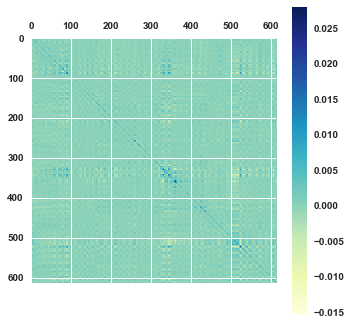

'Show the matrix elements corresponding to carbon atoms or backbone'

In [19]:
'''variance-covariance matrix of atomic positions =~ dispersion matrix
    mean =~ centroid
    variance: diagonal
    covariance: off-diagonal'''

from matplotlib.pyplot import figure
figure(figsize=(18, 18))

print(traj.xyz.shape)
xyz = traj.xyz.reshape((-1, traj.n_atoms * 3))
print('reshaped xyz: ',xyz.shape)
print('*****************************************')
covar = np.cov(xyz[:], rowvar=False)
print('variance-covariance matrix: ',covar.shape)
print('min: ',covar.min())
print('max: ',covar.max())


plt.matshow(covar, cmap='YlGnBu')
plt.colorbar()
plt.show();


'''Show the matrix elements corresponding to carbon atoms or backbone'''

> ### &#10148; The diagonal of the covariance matrix contains the variances of the atomic positions. 
> ### &#10148; Taking the square root of the diagonal results in the so-called root-mean-square fluctuation (RMSF) of the atomic positions. 
> ### &#10148; A high RMSF corresponds to more flexible atoms. 

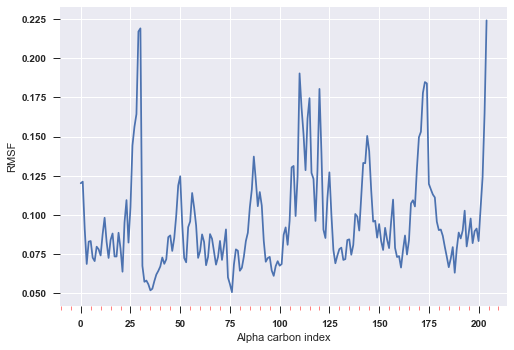

In [20]:
#rmsf = np.sqrt(np.diag(covar)[selection_xyz].reshape(-1, 3).sum(axis=1))
rmsf = np.sqrt(np.diag(covar).reshape(-1, 3).sum(axis=1))

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig,ax=plt.subplots()
ax.plot(rmsf)
ax.set_xlabel("Alpha carbon index")
ax.set_ylabel("RMSF")

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='major', length=7)
ax.tick_params(which='minor', length=4, color='r')
plt.show()

# <mark> Diagonalization of the covariance matrix <mark> 

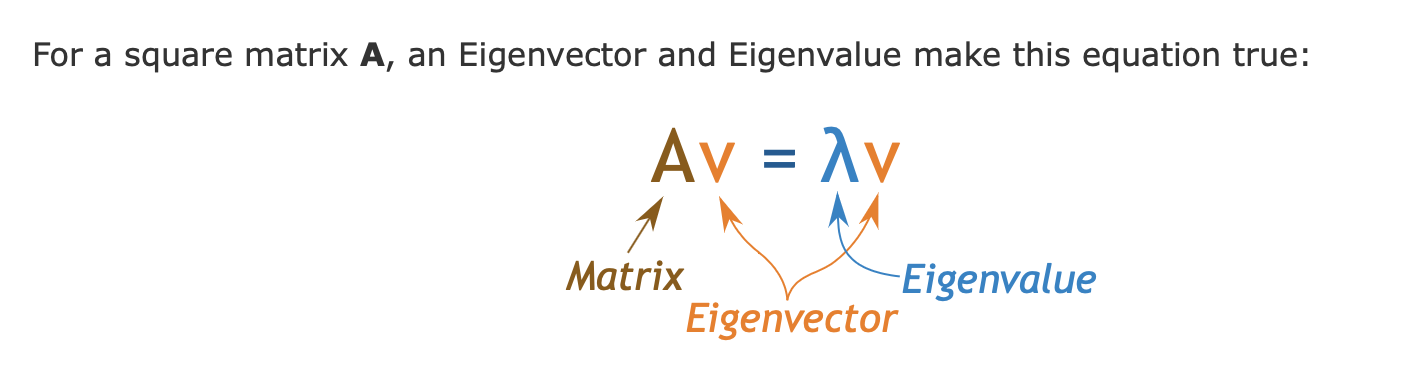

In [21]:
eignh = Image(filename=(home + '/gpcr/desmond/analysis/PCA/eignh.png'), width="750")
eignh

# <font color=darkcyan> Eigenvalues & Eigenvectors
> ### &#10148; Eigenvalues: 1D array (weight scores)
> ### &#10148; Eigenvectors: 2D square array or matrix (PCA)
> ### &#10148; The first six eigenvalues are practically zero and correspond to the frozen global rotation and translation
> ### &#10148; The remaining modes represent internal motions of the protein with increasing magnitude
> ### &#10148; In most modes, there is also no motion, which is partially caused by the short simulation time

(615,)
(615, 615)

[0.39116312]
************************************************************
rotation and translation (6): 


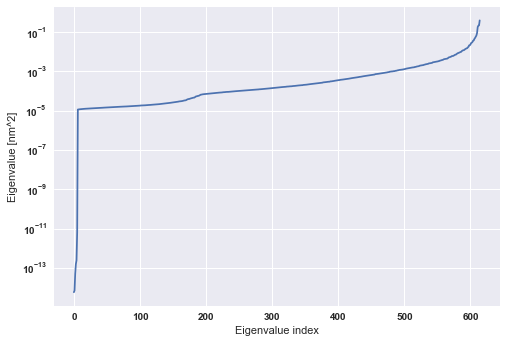

In [23]:
evals, evecs = np.linalg.eigh(covar)
print(evals.shape)
print(evecs.shape)
print('')

''' 5 most significant eigenvalues'''

print(evals[-1:])
print('************************************************************')
print('rotation and translation (6): ')
#print(evecs[-1:])

fig, ax = plt.subplots()

ax.semilogy(evals)
ax.set_xlabel("Eigenvalue index")
ax.set_ylabel("Eigenvalue [nm^2]");

# <font color=darkcyan> Projection on a PCA mode
> ### &#10148; Visualising projections into a reduced dimensional space
> ### &#10148; Project the trajectory on PCA mode(s) and follow the displacement along each mode

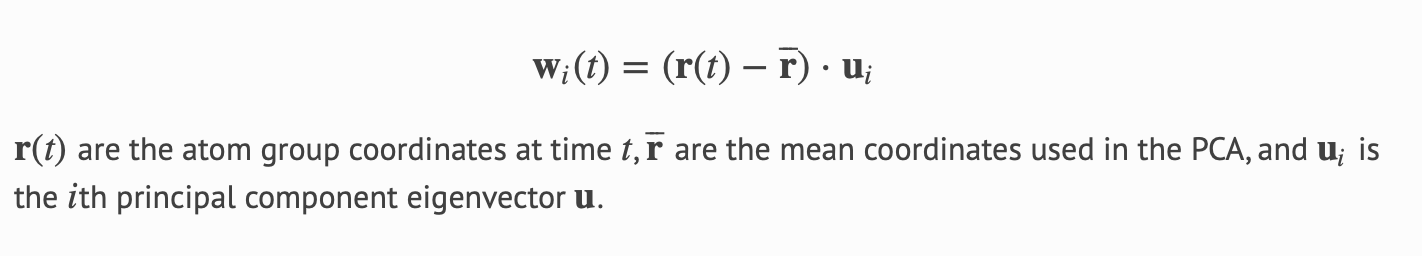

In [24]:
transform_wi = Image(filename=(home + '/gpcr/desmond/analysis/PCA/transform.png'), width="750")
transform_wi

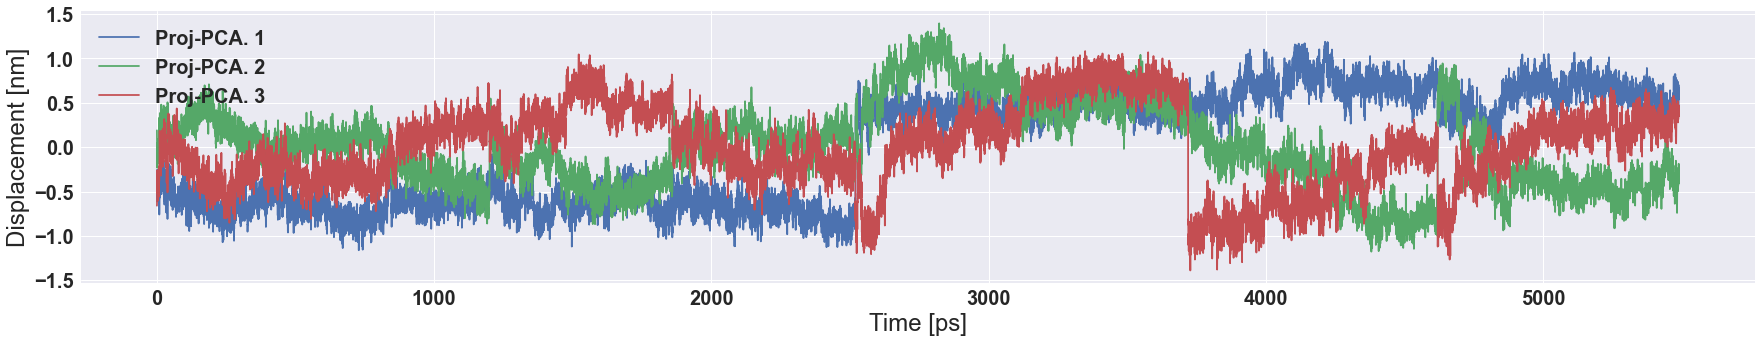

In [25]:
fig, ax = plt.subplots(figsize=(30, 5))
font = {'family':'Arial','weight':'bold','size': 22}
matplotlib.rc('font', **font)

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)

'''plot projections on the three-most significant principal modes'''

av = xyz.mean(axis=0)
for i in range(3):
    proj = np.dot(xyz - av.reshape(1, -1), evecs[:, -i - 1])
    ax.plot(t["Time (ps)"], proj, label=f"Proj-PCA. {i+1}")
ax.set_xlabel("Time [ps]", fontsize=24)
ax.set_ylabel("Displacement [nm]",fontsize=24 )
ax.legend(loc=0, fontsize=20);

#  <font color=darkcyan> Filtering the MD trajectory
### &#10148; Visualize the motion in one or more modes by filtering the atomic positions, only retaining displacements along modes. 
### &#10148; Collect the projected modes and reconstruct the trajectory using only a few selected modes.

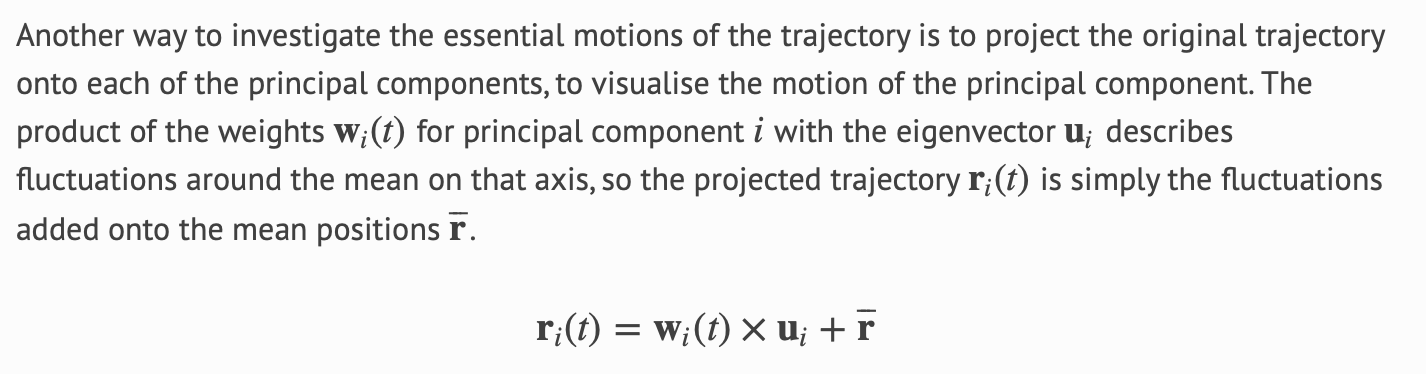

In [26]:
transform_wi = Image(filename=(home + '/gpcr/desmond/analysis/PCA/traj.png'), width="750")
transform_wi

In [27]:
import mdtraj as mdtraj

xyz_filter = 0

'''motions along the three most significant modes are retained'''
for i in 0, 1, 2:
    evec = evecs[:, -i - 1]
    '''transform (w(i))'''
    proj = np.dot(xyz - av.reshape(1, -1), evec)
    '''w(i) cross u(i)'''
    xyz_filter += np.outer(proj, evec)
'''adding mean'''
xyz_filter += av

'''cast the result back into an MDTraj trajectory and visualize'''
traj_filter = mdtraj.Trajectory(xyz_filter.reshape(-1, traj.n_atoms, 3), traj.topology)
view_filter = nv.show_mdtraj(traj_filter)
view_filter.add_representation("ball+stick", selection="protein")
view_filter

NGLWidget(max_frame=22874)

In [28]:
'''1st principal component eigenvector is associated 
    with largest eigenvalue (w**2) 
    Xv1=z1 (1st principal component, Var(z1)=w**2/N)'''

amplitude = np.sqrt(evals.max())

xyz_extra = np.outer(
    np.linspace(-amplitude, amplitude, 100), evecs[:, -1]) + av

traj_extra = mdtraj.Trajectory(
    xyz_extra.reshape(-1, traj.n_atoms, 3), traj.topology)
view_extra = nv.show_mdtraj(traj_extra)
view_extra.add_representation("ball+stick", selection="protein")
view_extra

NGLWidget(max_frame=99)